# Redes Neurais Recorrentes
### Previsão do preço de abertura e alta da bolsa (PETR4) utilizando preço de abertura como previsor.
#### Por Leonardo Bonifácio

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,CuDNNLSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [2]:
base = pd.read_csv('petr4-treinamento.csv')
base = base.dropna() # Retirando valores nulos
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


### Pré - processamento
Primeiramente, é necessário dividir a base para o atributo previsor/a ser previsto (Open) e o segundo a ser previsto (High).

In [3]:
X_treinamento = base.iloc[:,1:2].values # Open
X_alta = base.iloc[:,2:3].values # Alta

Para melhorar a velocidade de processamento, é necessário normalizar os dados:

In [4]:
normalizador = MinMaxScaler(feature_range=(0,1))

X_treinamento_normalizado = normalizador.fit_transform(X_treinamento)
X_alta_normalizado = normalizador.fit_transform(X_alta)

### Matriz de previsores e preços
Nesta etapa, é criada a estrutura em matriz dos preços reais e seus previsores. A variável *time* representa o número de dias que serão usados para previsão do preço atual.

In [5]:
previsores = []
preco_real_open = []
preco_real_high = []

time = 30

for i in range(time, len(X_treinamento_normalizado)):
    previsores.append(X_treinamento_normalizado[i-time:i,0])
    preco_real_open.append(X_treinamento_normalizado[i,0])
    preco_real_high.append(X_alta_normalizado[i,0])

# Transformação de lista para np array
previsores, preco_real_high, preco_real_open = np.array(previsores), np.array(preco_real_high), np.array(preco_real_open)

# Mudando dimensões para formato do Keras (batch_size, timesteps, input_dim)
previsores = np.reshape(previsores, (previsores.shape[0], time, 1))

# Concatenando os preços de Open e High 
preco_real_todos = np.column_stack((preco_real_open, preco_real_high))
preco_real_todos

array([[0.65116274, 0.66311202],
       [0.66424419, 0.67426079],
       [0.67344961, 0.67038294],
       ...,
       [0.57122093, 0.57537562],
       [0.57655039, 0.57489089],
       [0.57655039, 0.57343674]])

### Criação da RNN
Com os dados tratados e organizados, cria-se a Rede Neural Recorrente.

In [6]:
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50)) # Sem return na última camada LSTM
regressor.add(Dropout(0.2))

regressor.add(Dense(units=2, activation = 'linear')) # Camada de saída

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

Por fim, o treinamento do modelo é feito.

In [7]:
regressor.fit(previsores, preco_real_todos, epochs=100, batch_size=8, verbose=True)

Epoch 1/100
1212/1212 [==============================] - 33s 27ms/step - loss: 0.0162 - mean_absolute_error: 0.0935
Epoch 2/100
1212/1212 [==============================] - 32s 26ms/step - loss: 0.0082 - mean_absolute_error: 0.0684
Epoch 3/100
1212/1212 [==============================] - 30s 25ms/step - loss: 0.0064 - mean_absolute_error: 0.0611
Epoch 4/100
1212/1212 [==============================] - 30s 25ms/step - loss: 0.0054 - mean_absolute_error: 0.0554
Epoch 5/100
1212/1212 [==============================] - 31s 26ms/step - loss: 0.0047 - mean_absolute_error: 0.0518
Epoch 6/100
1212/1212 [==============================] - 29s 24ms/step - loss: 0.0038 - mean_absolute_error: 0.0466
Epoch 7/100
1212/1212 [==============================] - 29s 24ms/step - loss: 0.0037 - mean_absolute_error: 0.0458
Epoch 8/100
1212/1212 [==============================] - 30s 24ms/step - loss: 0.0030 - mean_absolute_error: 0.0420
Epoch 9/100
1212/1212 [==============================] - 30s 24ms/step -

1212/1212 [==============================] - 30s 25ms/step - loss: 0.0011 - mean_absolute_error: 0.0244
Epoch 71/100
1212/1212 [==============================] - 32s 26ms/step - loss: 0.0010 - mean_absolute_error: 0.0243
Epoch 72/100
1212/1212 [==============================] - 31s 26ms/step - loss: 0.0011 - mean_absolute_error: 0.0252
Epoch 73/100
1212/1212 [==============================] - 32s 26ms/step - loss: 0.0010 - mean_absolute_error: 0.0242
Epoch 74/100
1212/1212 [==============================] - 31s 26ms/step - loss: 0.0010 - mean_absolute_error: 0.0239
Epoch 75/100
1212/1212 [==============================] - 31s 26ms/step - loss: 0.0011 - mean_absolute_error: 0.0246
Epoch 76/100
1212/1212 [==============================] - 31s 26ms/step - loss: 0.0011 - mean_absolute_error: 0.0247
Epoch 77/100
1212/1212 [==============================] - 31s 25ms/step - loss: 0.0011 - mean_absolute_error: 0.0242 3s - loss: 0.0011 - mean_absol
Epoch 78/100
1212/1212 [======================

### Validação com base de teste
Para validação e posteriormente obtenção dos resultados, utiliza-se a mesma lógica da base de treinamento e depois o método *predict.

In [8]:
base_teste = pd.read_csv('petr4-teste.csv')

preco_real_open_teste = base_teste.iloc[:,1:2].values # Open
preco_real_high_teste = base_teste.iloc[:,2:3].values # Alta 

Um rearranjo é feito para obter um vetor com todos os valores atuais e previsores para o tempo estipulado.

In [9]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)

entradas = base_completa[len(base_completa) - len(base_teste) - time:].values
entradas = entradas.reshape(-1,1)

Normalizando:

In [10]:
entradas = normalizador.transform(entradas)

Fazendo a matriz de previsores e preços pra base de teste:

In [11]:
X_teste = []

for i in range(time, len(entradas)):
    X_teste.append(entradas[i-time:i, 0])

# Transformação de lista para np array    
X_teste = np.array(X_teste)

# Mudando dimensões para formato do Keras (batch_size, timesteps, input_dim)
X_teste = np.reshape(X_teste, (X_teste.shape[0], time, 1))

### Resultados

In [12]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes) # Necessário inverter a normalização

In [13]:
def exibirResultados():
    print('Abertura depois alta')
    print()
    for i in range(len(previsoes)):
        print('Previsão:', round(previsoes[i][0],4),'\t',round(previsoes[i][1],4), '\t\tValor real:', round(preco_real_open_teste[i][0],4), '\t', round(preco_real_high_teste[i][0],4))
    print()

In [14]:
exibirResultados()

Abertura depois alta

Previsão: 16.2325 	 16.4242 		Valor real: 16.19 	 16.55
Previsão: 16.3097 	 16.5023 		Valor real: 16.49 	 16.72
Previsão: 16.5816 	 16.778 		Valor real: 16.78 	 16.96
Previsão: 16.8789 	 17.0792 		Valor real: 16.7 	 16.86
Previsão: 16.8462 	 17.0454 		Valor real: 16.74 	 17.03
Previsão: 16.8613 	 17.0604 		Valor real: 17.03 	 17.16
Previsão: 17.1031 	 17.3056 		Valor real: 16.92 	 17.05
Previsão: 17.0412 	 17.2424 		Valor real: 16.88 	 17.3
Previsão: 17.0054 	 17.206 		Valor real: 17.04 	 17.41
Previsão: 17.127 	 17.3293 		Valor real: 17.32 	 17.44
Previsão: 17.3951 	 17.6013 		Valor real: 17.35 	 17.84
Previsão: 17.4605 	 17.6674 		Valor real: 17.92 	 18.36
Previsão: 17.9837 	 18.1981 		Valor real: 18.35 	 18.53
Previsão: 18.4082 	 18.6284 		Valor real: 18.31 	 18.42
Previsão: 18.4276 	 18.6473 		Valor real: 18.26 	 18.47
Previsão: 18.3623 	 18.5806 		Valor real: 18.4 	 18.46
Previsão: 18.4483 	 18.6678 		Valor real: 18.42 	 19.63
Previsão: 18.4767 	 18.6966 		Va

### Visualização Gráfica

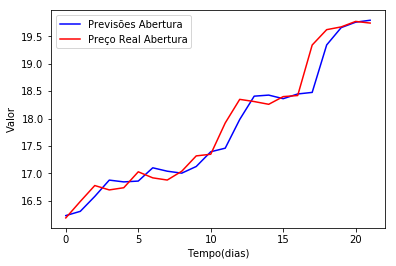

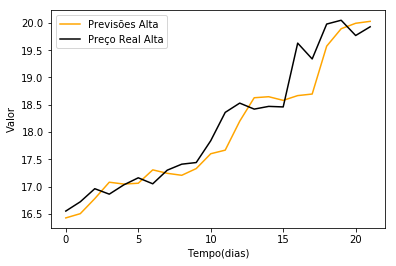

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(previsoes[:,0], color = 'blue', label = "Previsões Abertura")
plt.plot(preco_real_open_teste, color = "red", label = "Preço Real Abertura")
plt.xlabel("Tempo(dias)")
plt.ylabel("Valor")
plt.legend()
plt.show()

plt.plot(previsoes[:,1], color = 'orange', label = "Previsões Alta")
plt.plot(preco_real_high_teste, color = "black", label = "Preço Real Alta")
plt.xlabel("Tempo(dias)")
plt.ylabel("Valor")
plt.legend()
plt.show()